# Activation Functions

![Status](https://img.shields.io/static/v1.svg?label=Status&message=Finished&color=brightgreen)
[![Source](https://img.shields.io/static/v1.svg?label=GitHub&message=Source&color=181717&logo=GitHub)](https://github.com/particle1331/inefficient-networks/blob/master/docs/notebooks/tensorflow/03-tensorflow-activations.ipynb)
[![Stars](https://img.shields.io/github/stars/particle1331/inefficient-networks?style=social)](https://github.com/particle1331/inefficient-networks)

---


## Introduction

In this notebook, we will take a closer look at popular activation functions and investigate their effect on optimization properties in neural networks.
Activation functions are a crucial part of deep learning models as they add the nonlinearity to neural networks.
There is a great variety of activation functions in the literature, and some are more beneficial than others.
The goal of this tutorial is to show the importance of choosing a good activation function (and how to do so), and what problems might occur if we don't.

<br>

```{margin}
𝗔𝘁𝘁𝗿𝗶𝗯𝘂𝘁𝗶𝗼𝗻: This notebook is based on [Tutorial 3: Activation Functions](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial3/Activation_Functions.html) (PyTorch). The adapted version here is published with kind permission of the author.
```

In [1]:
import math
import random
import warnings

import tensorflow as tf
import tensorflow.keras as kr
import tensorflow_datasets as tfds

import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_inline import backend_inline


warnings.simplefilter(action="once")
backend_inline.set_matplotlib_formats('svg')

seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.8.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Commonly used activations

As a first step, we will implement some common activation functions by ourselves. Of course, most of them can also be found in the `kr.layers` module. However, we'll write our own functions here for better understanding and insights.

For an easier time of comparing various activation functions, we start with defining a base class from which all our future modules will inherit. Every activation function will be a Keras layer so that we can integrate them nicely in a network. Note that every Keras layer has a `get_config()` which we can update to include parameters for some activation functions.

In [2]:
class ActivationFunction(kr.layers.Layer):
    def __init__(self):
        super().__init__()

# Test
a = ActivationFunction()
a.get_config()

{'name': 'activation_function', 'trainable': True, 'dtype': 'float32'}

Next, we implement two of the "oldest" activation functions that are still commonly used for various tasks: sigmoid and tanh. 
Both the sigmoid and tanh activation can be also found as Keras functions (`kr.activations.sigmoid`, `kr.activations.tanh`). 
Here, we implement them by hand:

In [3]:
class Sigmoid(ActivationFunction):
    def call(self, x):
        return 1 / (1 + tf.math.exp(-x))

    
class Tanh(ActivationFunction):
    def call(self, x):
        exp_x, exp_neg_x = tf.math.exp(x), tf.math.exp(-x)
        return (exp_x - exp_neg_x) / (exp_x + exp_neg_x)

Another popular activation function that has allowed the training of deeper networks, is the Rectified Linear Unit (ReLU). Despite its simplicity of being a piecewise linear function, ReLU has one major benefit compared to sigmoid and tanh: a strong, stable gradient for a large range of values. Based on this idea, a lot of variations of ReLU have been proposed, of which we will implement the following three: LeakyReLU, ELU, and Swish. 

LeakyReLU replaces the zero settings in the negative part with a smaller slope to allow gradients to flow also in this part of the input. Similarly, ELU replaces the negative part with an exponential decay. The third, most recently proposed activation function is Swish, which is actually the result of a large experiment with the purpose of finding the “optimal” activation function. Compared to the other activation functions, Swish is both smooth and non-monotonic (i.e. contains a change of sign in the gradient). This has been shown to prevent dead neurons as in standard ReLU activation, especially for deep networks. If interested, a more detailed discussion of the benefits of Swish can be found in [this paper](https://arxiv.org/abs/1710.05941). Note that out of all activations, only Swish has maximum gradient greater than 1.

Let’s implement the four activation functions below:

In [4]:
class ReLU(ActivationFunction):
    def call(self, x):
        return tf.where(x > 0, x, [0])
    

class LeakyReLU(ActivationFunction):
    def __init__(self, alpha=0.1):
        super().__init__()
        self.alpha = tf.Variable(alpha, trainable=False)
    
    def get_config(self):
        config = super().get_config()
        config.update({'alpha': self.alpha})
        return config

    def call(self, x):
        return tf.where(x > 0, x, x * self.get_config()["alpha"])


class ELU(ActivationFunction):
    def call(self, x):
        # For some reason `tf.exp(x) - c` is not registered in the GPU
        return tf.where(x > 0, x, tf.exp(x) + (-1.0))
    

class Swish(ActivationFunction):
    def call(self, x):
        return x * kr.activations.sigmoid(x)

For later usage, we summarize all our activation functions in a dictionary mapping the name to the class object. In case you implement a new activation function by yourself, add it here to include it in future comparisons as well:

In [5]:
activation_by_name = {
    "sigmoid": Sigmoid,
    "tanh": Tanh,
    "relu": ReLU,
    "leakyrelu": LeakyReLU,
    "elu": ELU,
    "swish": Swish,
}

### Plotting activation values

To get an idea of what each activation function actually does, we will visualize them in the following. 
Next to the actual activation value, the gradient of the function is an important aspect as it is crucial for optimizing the neural network. 
TensorFlow allows us to compute the gradients `∂z/∂x` using `tape.gradient(z, x)`. The resulting gradients has the same shape as `x`. Below we will let `x` be all trainable parameters of the network, which can be huge. However, TensorFlow is able to calculate everything in an efficient manner with a single call (instead of calling `.gradient` for each weight and persisting the tape).

In [6]:
def get_grads(activation, x):
    """Compute gradient of activation with respect to x."""
    
    with tf.GradientTape() as tape:
        tape.watch(x)
        y = activation_by_name[activation]()(x)
        z = tf.reduce_sum(y)

    # Trick: ∂(y1 + y2)/∂x1 = ∂y1/∂x1 stored in x1.
    return tape.gradient(z, x)

Now we can visualize all our activation functions including their gradients:

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2022-07-08 02:20:42.842632: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.


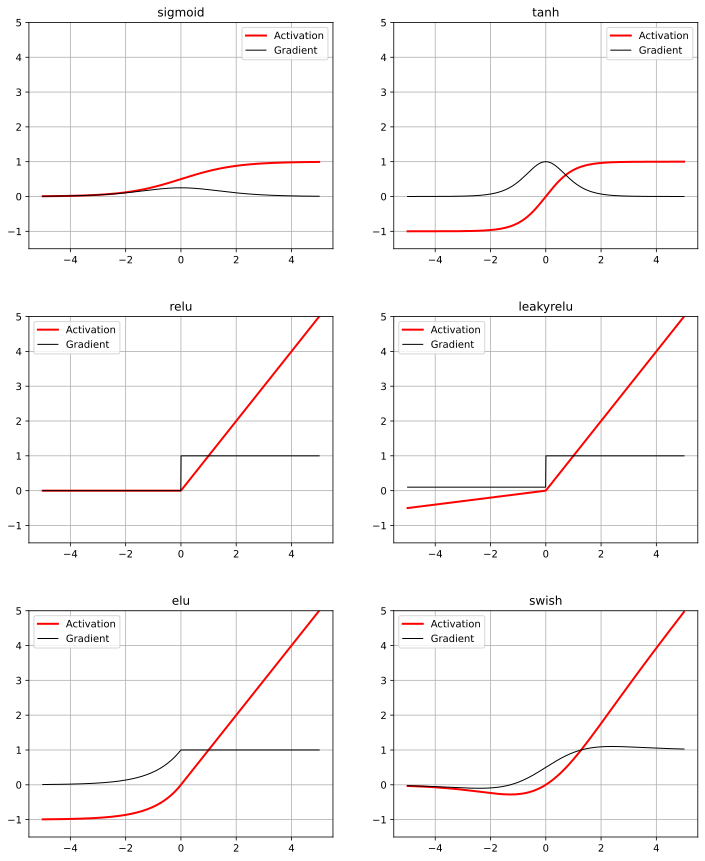

In [7]:
def plot_activation(activation, ax, x):
    """Plot (x, activation(x)) on axis object ax."""

    # Get output and gradients from input space x.
    y = activation_by_name[activation]()(x)
    y_grads = get_grads(activation, x)

    # Convert to numpy for plotting
    x, y, y_grads = x.numpy(), y.numpy(), y_grads.numpy()
    
    # Plotting
    ax.plot(x, y, linewidth=2, color='red', label="Activation")
    ax.plot(x, y_grads, linewidth=1, color='black', label="Gradient")
    ax.set_title(activation)
    ax.legend()
    ax.grid()
    ax.set_ylim(-1.5, x.max())


# Plotting
x = tf.reshape(tf.linspace(-5, 5, 1000), (-1, 1))
rows = math.ceil(len(activation_by_name.keys()) / 2.0)
fig, ax = plt.subplots(rows, 2, figsize=(12, rows*5))
for i, activation in enumerate(activation_by_name.keys()):
    plot_activation(activation, ax[divmod(i, 2)], x) # divmod(m, n) = m // n, m % n

fig.subplots_adjust(hspace=0.3)
plt.show()

## Analyzing the effect of activation functions

After implementing and visualizing the activation functions, we are aiming to gain insights into their effect. 
We do this by using a simple neural network trained on [FashionMNIST](https://github.com/zalandoresearch/fashion-mnist) and examine various aspects of the model, including the performance and gradient flow.

### Preliminaries

**Base network.** Let's set up a base neural network. The chosen network views the images as 1D tensors and pushes them through a sequence of linear layers and a specified activation function. Hence, an MLP with flattened images as input. Each neuron in the next layer has a weight vector that acts as a filter for the whole image. Projecting the image in this filter which returns a real number measuring the degree of projection. Thus, its important to normalize each image. The numbers form a vector which is processed in the same manner in the next layer. Feel free to experiment with other network architectures.

In [8]:
def base_network(
    activation,
    num_classes=10,
    hidden_sizes=(512, 256, 256, 128)
):
    """Return a fully-connected network with given activation and layer widths."""

    # Add dense hidden layers + activation layer
    model = kr.Sequential()
    for j in range(len(hidden_sizes)):
        model.add(kr.layers.Dense(hidden_sizes[j]))
        model.add(activation_by_name[activation]())

    # Add linear logit layer
    model.add(kr.layers.Dense(units=num_classes))
    
    return model

Testing: 

In [9]:
model = base_network(activation='leakyrelu')
model.build(input_shape=(None, 784))
model.summary()

x = tf.random.normal(shape=(1, 784))
tf.print(model(x))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               401920    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 512)               1         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 256)               1         
                                                                 
 dense_2 (Dense)             (None, 256)               65792     
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 256)               1         
                                                                 
 dense_3 (Dense)             (None, 128)               3

The trainable parameters of the network can be accessed as follows. This skips the parameters of the LeakyReLU activations which are nontrainable.

In [10]:
print("All trainable variables:")
for v in model.trainable_variables:
    tf.print(f"  {str(v.name):<15}\t {str(v.shape):<15}")

All trainable variables:
  dense/kernel:0 	 (784, 512)     
  dense/bias:0   	 (512,)         
  dense_1/kernel:0	 (512, 256)     
  dense_1/bias:0 	 (256,)         
  dense_2/kernel:0	 (256, 256)     
  dense_2/bias:0 	 (256,)         
  dense_3/kernel:0	 (256, 128)     
  dense_3/bias:0 	 (128,)         
  dense_4/kernel:0	 (128, 10)      
  dense_4/bias:0 	 (10,)          


**Dataset.** [FashionMNIST](https://github.com/zalandoresearch/fashion-mnist) is a more complex version of MNIST and contains black-and-white images of clothes instead of digits. The 10 classes include trousers, coats, shoes, bags and more. To load this dataset, we will make use of `tensorflow_datasets`.

In [11]:
FMNIST, FMNIST_info = tfds.load(
    'fashion_mnist', 
    data_dir='./data', 
    with_info=True, 
    shuffle_files=False
)

print(FMNIST_info)

tfds.core.DatasetInfo(
    name='fashion_mnist',
    full_name='fashion_mnist/3.0.1',
    description="""
    Fashion-MNIST is a dataset of Zalando's article images consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.
    """,
    homepage='https://github.com/zalandoresearch/fashion-mnist',
    data_path='./data/fashion_mnist/3.0.1',
    download_size=29.45 MiB,
    dataset_size=36.42 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{DBLP:journals/corr/abs-1708-07747,
      author    = {Han Xiao and
                   Kash

In [12]:
# Transformations applied on each image. 
def transform_image(image):
    """Rescale image linearly from [0, 255] to [0, 1]."""
    return tf.reshape(kr.layers.Rescaling(1./255)(image), (-1,))

train_dataset, test_dataset = FMNIST['train'], FMNIST['test']
train_dataset = train_dataset.map(lambda x: (transform_image(x['image'][:, :, 0]), x['label']))
test_dataset = test_dataset.map(lambda x: (transform_image(x['image'][:, :, 0]), x['label']))

# Create fixed batch for all subsequent experiments
fixed_batch = next(iter(train_dataset.batch(4096)))

2022-07-08 02:20:43.704043: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-07-08 02:20:43.882651: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Let's visualize a few images to get an impression of the data.

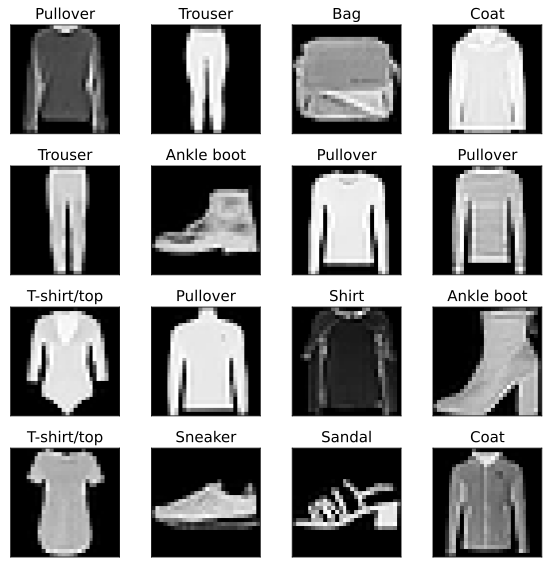

In [13]:
images, labels = fixed_batch
class_map = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot",
}

fig = plt.figure(figsize=(8, 8))
for i in range(16):
    image = images[i].numpy()
    label = labels[i]
    ax = fig.add_subplot(4, 4, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(image.reshape(28, 28), cmap="gray")
    ax.set_title(class_map[label.numpy()], size=15)
    
plt.tight_layout()
plt.show()

### Gradient flow after initialization

As mentioned previously, one important aspect of activation functions is how they propagate gradients through the network. Imagine we have a very deep neural network with more than 50 layers. The gradients for the input layer, i.e. the very first layer, have passed >50 times the activation function, but we still want them to be of a reasonable size. If the gradient through the activation function is in expectation considerably smaller than 1, our gradients will vanish until they reach the input layer. If the gradient through the activation function is larger than 1, the gradients exponentially increase and might explode. These are known as the problems of **vanishing** and **exploding gradients**.

In [14]:
def plot_gradient_distribution(model, activation_name, color="C0"):
    """Plot histogram of gradients after one backprop from a batch of inputs."""

    # Get one batch of images
    images, labels = fixed_batch

    # Pass the batch through the network, and calculate the gradients for the weights
    loss_fn = kr.losses.SparseCategoricalCrossentropy(from_logits=True)
    with tf.GradientTape(persistent=True) as tape:
        preds = model(images)
        loss = loss_fn(labels, preds)

    # Exclude the bias to reduce the number of plots
    grads_dict = {}
    for i, layer in enumerate(model.layers):
        grads = tape.gradient(loss, layer.variables)

        # Get kernel weights
        for j in range(len(layer.variables)):
            w = layer.variables[j]
            if (not w.trainable) or ("bias" in w.name):
                continue
            grads_dict[f"{w.name.split('/')[0].split('_')[0]}_{i+1}"] = grads[j].numpy().reshape(-1)

    # Plotting
    grads_dict_ = {}
    max_n = max([len(grads_dict[k]) for k in grads_dict.keys()])

    for k in grads_dict.keys():
        data = grads_dict[k]
        data = np.concatenate([data, np.array([np.nan]*(max_n - len(data)))])
        grads_dict_[k] = data

    _, ax = plt.subplots(1, 1, figsize=(10, 3))
    sns.violinplot(ax=ax, data=pd.DataFrame(grads_dict_), color=color, label=activation_name)
    ax.set_ylabel(r'${\nabla}_w L$')
    ax.legend([activation_name], loc='upper left')


To get a feeling of how every activation function influences the gradients, we can look at a freshly initialized network and measure the gradients for each parameter for a batch of 256 images. That is, we pass 256 images, backpropagate gradients based on the available labels for this images, then look at the histogram of gradient values. In particular, we look for vanishing and exploding gradients. 

```{margin}
Note that layers are **1-indexed**.
```

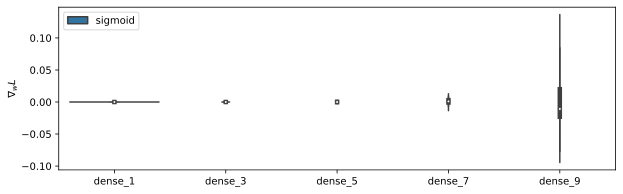

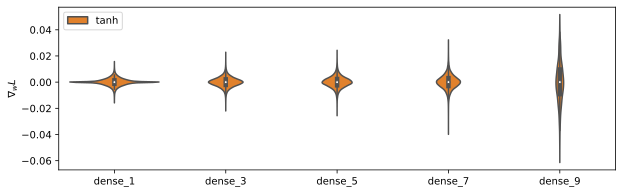

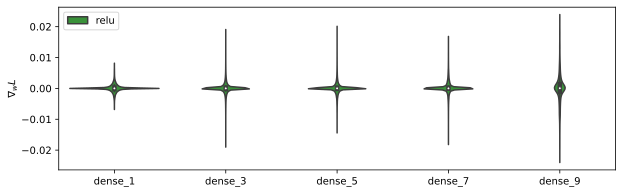

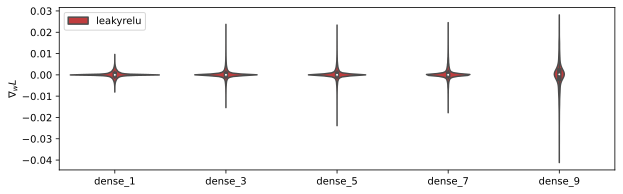

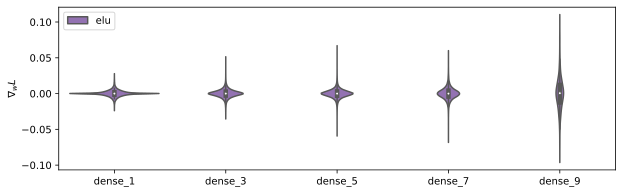

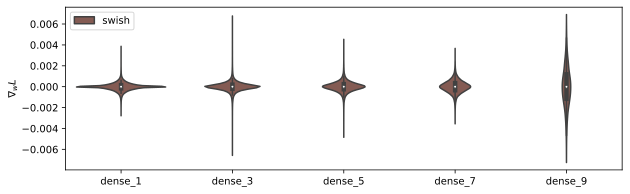

In [15]:
for i, activation in enumerate(activation_by_name.keys()):
    model = base_network(activation=activation)
    plot_gradient_distribution(model, activation_name=activation, color=f"C{i}")

The sigmoid activation function shows a clearly undesirable behavior. While the gradients for the output layer are very large with up to $0.1,$ the input layer has the lowest gradient norm across all layers where the gradient are  mostly zero. This is due to its small maximum gradient of $\frac{1}{4},$ and finding a suitable learning rate across all layers is not possible in this setup. All the other activation functions show to have similar gradient norms across all layers. Interestingly, the ReLU activation has a spike around $0$ which is caused by its zero-part on the left, and dead neurons (we will take a closer look at this later on).

Note that additionally to the activation, the weight and bias initialization can be crucial. By default, TensorFlow uses the Glorot uniform initialization for linear layers optimized for sigmoid activations. Note that in our implementation we used Kaiming normal initialization which is optimized for ReLU activations. In the [Initialization and Optimization](https://particle1331.github.io/inefficient-networks/notebooks/tensorflow/04-tensorflow-optim-init.html) notebook, we will take a closer look at initialization, but assume for now that the Kaiming initialization works for all activation functions reasonably well.

### Training with different activations

Next, we want to train our model with different activation functions on FashionMNIST and compare the gained performance. All in all, our final goal is to achieve the best possible performance on a dataset of our choice. 
Therefore, we write a training loop in the next cell including a validation after every epoch and a final test on the best model:

In [16]:
def train_model(model, train_loader, test_loader, batch_size=256, max_epochs=50):
    """Train model on FashionMNIST. Restore best weights on early stop."""

    # Defining optimizer, loss, metrics, and early stopping callback
    optimizer = kr.optimizers.SGD(learning_rate=1e-2, momentum=0.9)
    loss = kr.losses.SparseCategoricalCrossentropy(from_logits=True)
    metrics = kr.metrics.SparseCategoricalAccuracy()
    
    early_stopping = kr.callbacks.EarlyStopping(
        monitor='val_loss', 
        patience=7, 
        restore_best_weights=True
    )
    
    # Build and compile
    model.build(input_shape=(None, 784))
    model.compile(
        optimizer=optimizer,
        loss=loss, 
        metrics=[metrics]
    )

    # Train model
    history = model.fit(
        train_loader, 
        epochs=max_epochs,
        steps_per_epoch=np.floor(len(train_dataset) / batch_size), 
        verbose=0,
        validation_data=test_loader,
        validation_steps=1,
        callbacks=[early_stopping],
    )
    
    # Return history and final test accuracy
    test_acc = model.evaluate(test_dataset.batch(1000), verbose=0)
    return history, test_acc[1] # .evaluate returns [loss, accuracy]

Iterating over all activation functions:

2022-07-08 02:20:49.946520: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


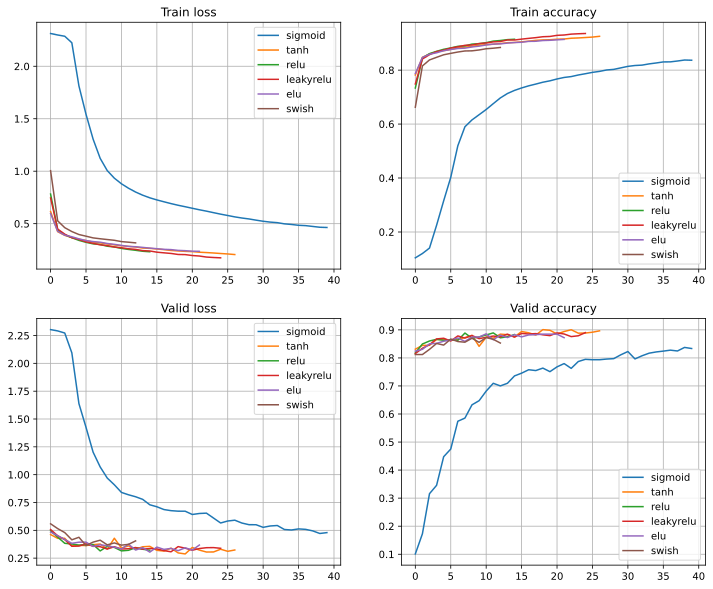

In [17]:
# Recall shuffle, batch, repeat pattern to create epochs
BATCH_SIZE = 256
NUM_EPOCHS = 40

train_loader = train_dataset.shuffle(buffer_size=1000)
train_loader = train_loader.batch(batch_size=BATCH_SIZE, drop_remainder=True)
train_loader = train_loader.prefetch(buffer_size=BATCH_SIZE)
train_loader = train_loader.repeat(NUM_EPOCHS)

test_loader = test_dataset.shuffle(buffer_size=4096)
test_loader = test_loader.batch(2048)

results = {}
trained_models = {}
model_history = {}
_, ax = plt.subplots(2, 2, figsize=(12, 10))

for activation in activation_by_name.keys():
    model = base_network(activation)
    history, test_acc = train_model(
        model, 
        train_loader=train_loader,
        test_loader=test_loader,
        batch_size=BATCH_SIZE,
        max_epochs=NUM_EPOCHS,
    )
    results[activation] = test_acc
    trained_models[activation] = model
    model_history[activation] = history
    
    # Plotting train loss
    n = len(history.history['loss'])
    ax[0, 0].set_title("Train loss")
    ax[0, 0].plot(range(n), history.history['loss'], label=activation)
    ax[0, 0].legend()
    ax[0, 0].grid(True)
    ax[1, 0].set_title("Valid loss")
    ax[1, 0].plot(range(n), history.history['val_loss'], label=activation)
    ax[1, 0].legend()
    ax[1, 0].grid(True)

    # Plotting accuracy
    ax[0, 1].set_title("Train accuracy")
    ax[0, 1].plot(range(n), history.history['sparse_categorical_accuracy'], label=activation)
    ax[0, 1].legend()
    ax[0, 1].grid(True)
    ax[1, 1].set_title("Valid accuracy")
    ax[1, 1].plot(range(n), history.history['val_sparse_categorical_accuracy'], label=activation)
    ax[1, 1].legend()
    ax[1, 1].grid(True)

Repeating the same experiment but not plotting sigmoid:

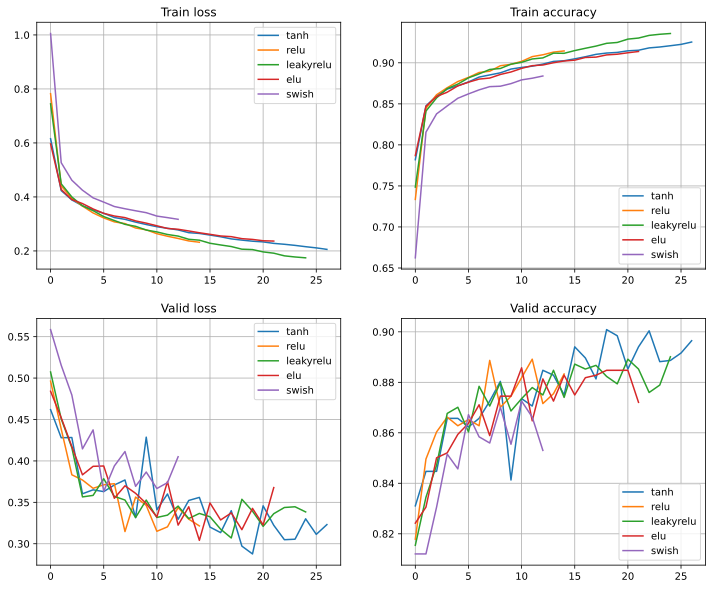

In [18]:
_, ax = plt.subplots(2, 2, figsize=(12, 10))

for activation in activation_by_name.keys():
    history = model_history[activation]
    if activation != "sigmoid":

        # Plotting train loss
        n = len(history.history['loss'])
        ax[0, 0].set_title("Train loss")
        ax[0, 0].plot(range(n), history.history['loss'], label=activation)
        ax[0, 0].legend()
        ax[0, 0].grid(True)
        ax[1, 0].set_title("Valid loss")
        ax[1, 0].plot(range(n), history.history['val_loss'], label=activation)
        ax[1, 0].legend()
        ax[1, 0].grid(True)

        # Plotting accuracy
        ax[0, 1].set_title("Train accuracy")
        ax[0, 1].plot(range(n), history.history['sparse_categorical_accuracy'], label=activation)
        ax[0, 1].legend()
        ax[0, 1].grid(True)
        ax[1, 1].set_title("Valid accuracy")
        ax[1, 1].plot(range(n), history.history['val_sparse_categorical_accuracy'], label=activation)
        ax[1, 1].legend()
        ax[1, 1].grid(True)

The final test accuracies are shown in the following table (these are from the best weights since we set `restore_best_weights` to `True` in our early stopping callback):

In [19]:
import pandas as pd
pd.DataFrame({k: [results[k]] for k in results.keys()})

,sigmoid,tanh,relu,leakyrelu,elu,swish
0,0.8262,0.8834,0.8746,0.884,0.8743,0.8547


Not surprisingly, the model using the sigmoid activation function has relatively bad performance. This is because of the low magnitudes of the gradients on layers near the input. All the other activation functions gain 
similar performance.

To have a more accurate conclusion, we would have to train the models for multiple seeds and look at the averages.
However, the "optimal" activation function also depends on many other factors (hidden sizes, number of layers, type of layers, task, dataset, optimizer, learning rate, etc.) so that a thorough grid search would not be useful in our case.

In the literature, activation functions that have shown to work well with deep networks are all types of ReLU functions we experiment with here, with small gains for specific activation functions in specific networks.

### Distribution of activation values

After we have trained the models, we can look at the actual activation values that find inside the model. For instance, how many neurons are set to zero in ReLU? Where do we find most values in Tanh?
To answer these questions, we can write a simple function which takes a trained model, applies it to a batch of images, and plots the histogram of the activations inside the network over the input batch. Note that we only look at the activations in the hidden and input layers excluding the logits layer (which is a linear layer).

In [20]:
def plot_activations_distribution(model, activation, color="C0"):
    """Plot activation density for output of each layer for one forward pass."""

    # We need to manually loop through the layers to save all activations
    images, _ = fixed_batch
    activations = {}
    for i, layer in enumerate(model.layers):
        if i == 0:
            activations[i] = layer(images)
        else:
            activations[i] = layer(activations[i-1])

    # Plotting. Skip input and classification layer
    max_n = max([len(activations[k].numpy().reshape(-1)) for k in activations.keys()])

    activations_ = {}
    for k in list(activations.keys())[:-1]:
        data = activations[k].numpy().reshape(-1)
        data = np.concatenate([data, np.array([np.nan]*(max_n - len(data)))])
        activations_[f"{''.join(model.layers[k].name.split('_')[:-1])}_{k+1}"] = data

    _, ax = plt.subplots(1, 1, figsize=(10, 3))
    sns.violinplot(ax=ax, data=pd.DataFrame(activations_), color=color, label=activation)
    ax.set_ylabel(r'${\phi}$')
    ax.tick_params(axis='x', labelrotation=30)

Plotting activations distribution of trained models:

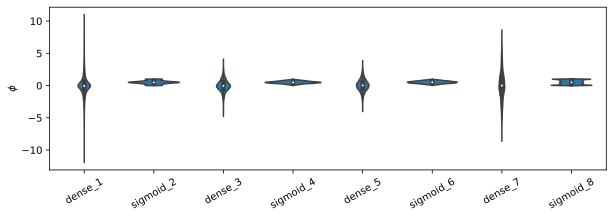

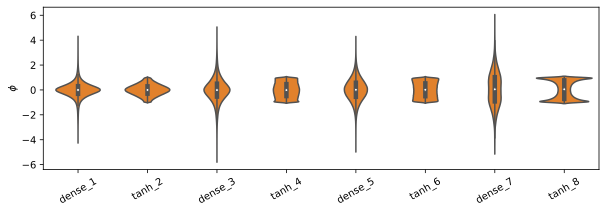

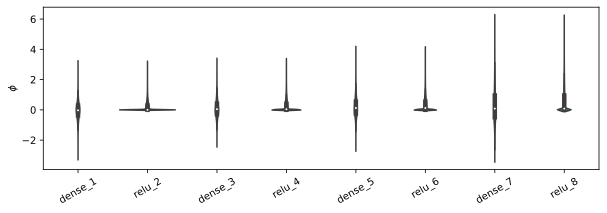

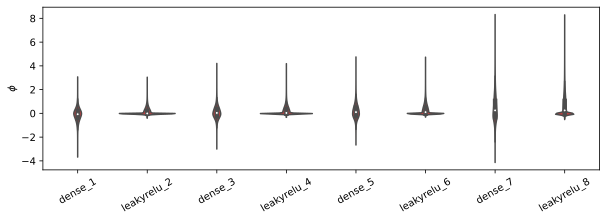

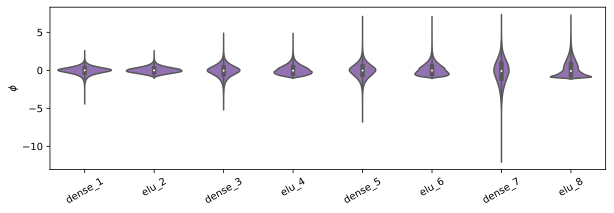

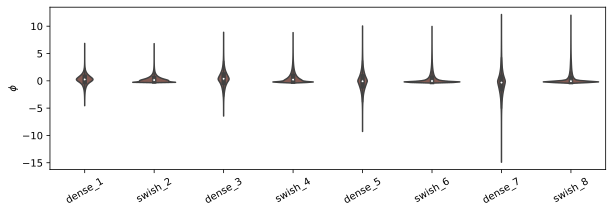

In [21]:
for i, activation in enumerate(activation_by_name.keys()):
    plot_activations_distribution(trained_models[activation], activation, color=f"C{i}")

As the model with sigmoid activation was not able to train properly, the activations are also less informative.

On the other hand, tanh shows a more diverse behavior. While for the input layer we experience a larger amount of neurons to be close to $-1$ and $1,$ where the gradients are close to zero, the activations in the two consecutive layers are closer to zero. This is probably because the input layers look for specific features in the input image, and the consecutive layers combine those together. The activations for the last layer are again more biased to the extreme points because the classification layer can be seen as a weighted average of those values (the gradients push the activations to those extremes).


ReLU has a strong peak at $0,$ as we initially expected. The effect of having no gradients for negative values is that the network does not have a Gaussian-like distribution after the linear layers, but a longer tail towards the positive values. LeakyReLU shows a very similar behavior while ELU follows again a more Gaussian-like distribution. Finally, Swish activation seems to lie in between, and it is worth noting that Swish uses significantly higher values than other activation functions.

As all activation functions show slightly different behavior although obtaining similar performance for our simple network, it becomes apparent that the selection of the "optimal" activation function really depends on many factors, and is not the same for all possible networks.

## Finding dead neurons in ReLU networks

One known drawback of the ReLU activation is the occurrence of "dead neurons", i.e. neurons with no gradient for any training input.
The issue of dead neurons is that as no gradient flows across the layer, and we cannot train the parameters of this neuron in the previous layer to obtain output values besides zero.

For dead (or dying) neurons to happen, the output value of a specific neuron of the linear layer before the ReLU has to be negative for all (or almost all) input images. 
Note that all gradients are also zero so that the weights will also not update if we introduce no new data. 
Considering the large number of neurons we have in a neural network, it is not unlikely for this to happen. 

To get a better understanding of how much of a problem this is, and when we need to be careful, we will measure how many dead neurons different networks have. For this, we implement a function which runs the network on the whole training set and records whether a neuron's activation magnitude is "small" (`<1e-8` by default) for majority of the data points (`0.99` by default):

In [22]:
def fraction_dead_neurons(model, threshold=0.99, eps=1e-8):
    """Fraction of neurons with small activations on one batch."""

    # Initialize counter for each layer
    count_zero_actn = {}
    for i, layer in enumerate(model.layers[:-1]):
        if isinstance(layer, kr.layers.Dense):
            layer_width = layer.get_weights()[1].shape
            count_zero_actn[i+1] = tf.zeros(layer_width)
    
    # Count zero activations during forward pass of one batch
    x = fixed_batch[0]
    for i, layer in enumerate(model.layers):
        x = layer(x)
        if isinstance(layer, ActivationFunction):
            count_zero_actn[i] += tf.reduce_sum(tf.cast(tf.abs(x) < eps, tf.float32), axis=0)

    # Dead = fraction of "zero" activations (over train set) exceeds threshold.
    print("Number of dead neurons:")
    for k in count_zero_actn.keys():
        num_dead = tf.reduce_sum(tf.cast((count_zero_actn[k] / x.shape[0]) >= threshold, tf.float32))
        total = count_zero_actn[k].shape[0]
        print(f"  {f'({k+1})':>4} {model.layers[k].__class__.__name__}: {int(num_dead):3}/{total:3} {f'({(100.0 * num_dead / total):.2f}%)':>8}")

**Zero network.** Testing with network with all neurons having zero output:

In [23]:
def zeros_init(net):
    for layer in net.layers:
        if isinstance(layer, kr.layers.Dense):
            layer.set_weights([tf.zeros(w.shape) for w in layer.get_weights()])

# Initialize with zero weights
net_zero = base_network(activation='relu')
net_zero.build(input_shape=(None, 784))
zeros_init(net_zero)

# Should sum to zero
tf.print(sum([tf.reduce_sum(v) for v in net_zero.variables]))

0


In [24]:
fraction_dead_neurons(net_zero) # Should be all dead

Number of dead neurons:
   (2) ReLU: 512/512 (100.00%)
   (4) ReLU: 256/256 (100.00%)
   (6) ReLU: 256/256 (100.00%)
   (8) ReLU: 128/128 (100.00%)


**Untrained network.** Let's measure the number of dead neurons for an untrained network:

In [25]:
net_relu = base_network(activation='relu', hidden_sizes=[512, 256, 256, 128])
net_relu.build(input_shape=(None, 784))
fraction_dead_neurons(net_relu)

Number of dead neurons:
   (2) ReLU:   8/512  (1.56%)
   (4) ReLU:  11/256  (4.30%)
   (6) ReLU:  21/256  (8.20%)
   (8) ReLU:  13/128 (10.16%)


We see that only a minor amount of neurons are dead, but that they increase with the depth of the layer.
In the long term, this is not a problem for the small number of dead neurons we have as the input to the neuron's layer is changed due to updates to the weights of lower layers. Such weights can be updated from gradients flowing into lower layers through alternate paths (i.e. across neurons in the same layer that are alive). Therefore, dead neurons can potentially become alive or active again. 

**Trained network.** How does this look like for a trained network with the same initialization?

In [26]:
trained_relu = trained_models['relu']
trained_relu.build(input_shape=(None, 784))
fraction_dead_neurons(trained_relu)

Number of dead neurons:
   (2) ReLU:  11/512  (2.15%)
   (4) ReLU:   7/256  (2.73%)
   (6) ReLU:   9/256  (3.52%)
   (8) ReLU:  10/128  (7.81%)


The number of dead neurons indeed decreased in the later layers. However, it should be noted that dead neurons are especially problematic in the input layer since there are no lower layers whose weights can be updated to shift the activations to be predominantly positive. Still, the input data has usually a sufficiently high standard deviation to reduce the risk of dead neurons.

**Untrained deep network.** Finally, we check how the number of dead neurons behaves with increasing layer depth. For instance, let’s take the following 10-layer neural network:

In [27]:
net_relu = base_network(activation='relu', hidden_sizes=[256, 256, 256, 256, 256, 128, 128, 128, 128, 128])
net_relu.build(input_shape=(None, 784))
fraction_dead_neurons(net_relu)

Number of dead neurons:
   (2) ReLU:   3/256  (1.17%)
   (4) ReLU:  18/256  (7.03%)
   (6) ReLU:  22/256  (8.59%)
   (8) ReLU:  23/256  (8.98%)
  (10) ReLU:  33/256 (12.89%)
  (12) ReLU:  24/128 (18.75%)
  (14) ReLU:  33/128 (25.78%)
  (16) ReLU:  32/128 (25.00%)
  (18) ReLU:  29/128 (22.66%)
  (20) ReLU:  39/128 (30.47%)


The number of dead neurons is significantly higher than before which harms the gradient flow especially in the first iterations. For instance, more than 25% of the neurons in the pre-last layer are dead which creates a considerable bottleneck. Hence, it is advisible to use other nonlinearities like Swish for very deep networks.

In [28]:
net_swish = base_network(activation='swish', hidden_sizes=[256, 256, 256, 256, 256, 128, 128, 128, 128, 128])
net_swish.build(input_shape=(None, 784))
fraction_dead_neurons(net_swish)

Number of dead neurons:
   (2) Swish:   0/256  (0.00%)
   (4) Swish:   0/256  (0.00%)
   (6) Swish:   0/256  (0.00%)
   (8) Swish:   0/256  (0.00%)
  (10) Swish:   0/256  (0.00%)
  (12) Swish:   0/128  (0.00%)
  (14) Swish:   0/128  (0.00%)
  (16) Swish:   0/128  (0.00%)
  (18) Swish:   0/128  (0.00%)
  (20) Swish:   0/128  (0.00%)


## Conclusion

In this notebook, we have reviewed a set of six activation functions (sigmoid, tanh, ReLU, LeakyReLU, ELU, and Swish) in neural networks, and discussed how they influence the gradient distribution across layers. Sigmoid tends to fail deep neural networks as the highest gradient it provides is 0.25 leading to vanishing gradients in early layers. All ReLU-based activation functions have shown to perform well, and besides the original ReLU, do not have the issue of dead neurons. When implementing your own neural network, it is recommended to start with a ReLU-based network and select the specific activation function based on the properties of the network.